In [1]:
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import datasets, transforms

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#добавим аугментацию к нашим тренировочным данным

In [3]:
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


выведем первые 10 фоток из датасеты с их метками

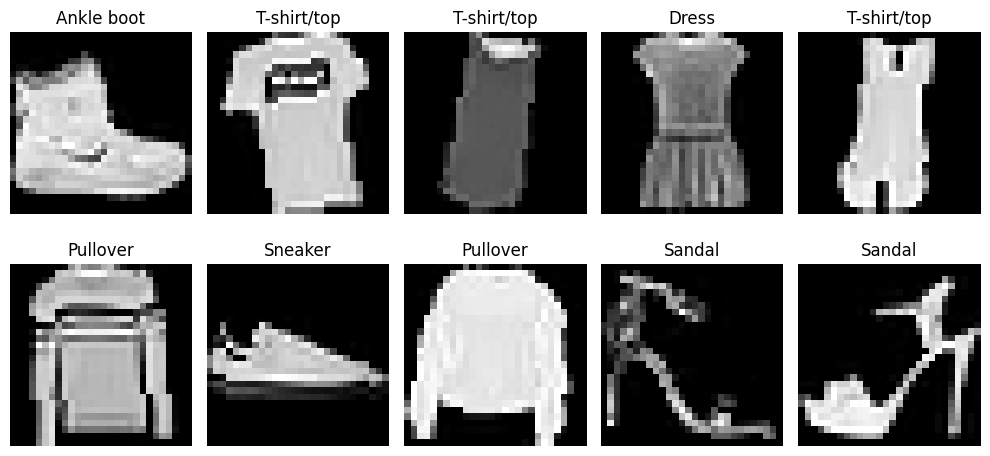

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    image, label = train_data[i]
    
    image = image.squeeze().numpy()
    image = (image * 0.5) + 0.5  
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

разделим датасет на тестовую и обучающую выборку

In [6]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True);
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False);
test_loader = DataLoader(test_data, batch_size=64)
#здесь добавил дополнительно тестовый датасет

In [34]:
def make_residual_block(in_channels):

    sub_block = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(in_channels),
    )

    def init_fn(self):
        nn.Module.__init__(self)
        self.sub_block = sub_block

    def forward_fn(self, x):
        return x + self.sub_block(x)

    ResidualModule = type(
        "DynamicResidualBlock",           
        (nn.Module, ),                    
        {
            "__init__": init_fn,         
            "forward": forward_fn         
        }
    )

    return ResidualModule()

model_with_cnn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    make_residual_block(in_channels=32),  # наш первый residual-блок
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    make_residual_block(in_channels=64),  # второй residual-блок
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10)
)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_cnn.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [29]:

summary(
    model_with_cnn,
    input_size=(1, 1, 28, 28),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=4
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
Sequential                               [1, 1, 28, 28]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 1, 28, 28]            [1, 32, 28, 28]           320                       [3, 3]
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           [1, 32, 28, 28]           64                        --
├─ReLU: 1-3                              [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
├─DynamicResidualBlock: 1-4              [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─Sequential: 2-1                   [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    │    └─Conv2d: 3-1                  [1, 32, 28, 28]           [1, 32, 28, 28]           9,248                     [3, 3]
│    │

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 5
no_improve = 0

epochs = 30
for epoch in range(epochs):
    model_with_cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_with_cnn(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss/len(train_loader)
    train_acc = 100*correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model_with_cnn.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_with_cnn(images)
            loss = loss_function(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss/len(val_loader)
    val_acc = 100*correct/total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model_with_cnn.state_dict(), 'best_cnn_model_augmented.pth')
        print(f'[SAVED] New best model at epoch {epoch+1}')
    else:
        no_improve += 1
    
    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
    
    if no_improve >= patience:
        print(f'\nEarly stopping triggered at epoch {epoch+1}')
        model_with_cnn.load_state_dict(torch.load('best_cnn_model_augmented.pth'))
        break

[SAVED] New best model at epoch 1
Epoch 1/30: Train Loss: 0.3318, Acc: 88.44% | Val Loss: 0.2586, Acc: 90.99%
Epoch 2/30: Train Loss: 0.3105, Acc: 88.96% | Val Loss: 0.2903, Acc: 90.00%
[SAVED] New best model at epoch 3
Epoch 3/30: Train Loss: 0.2912, Acc: 89.87% | Val Loss: 0.2516, Acc: 91.04%
[SAVED] New best model at epoch 4
Epoch 4/30: Train Loss: 0.2776, Acc: 90.25% | Val Loss: 0.2481, Acc: 91.29%
[SAVED] New best model at epoch 5
Epoch 5/30: Train Loss: 0.2678, Acc: 90.54% | Val Loss: 0.2425, Acc: 91.13%
[SAVED] New best model at epoch 6
Epoch 6/30: Train Loss: 0.2546, Acc: 90.98% | Val Loss: 0.2286, Acc: 91.86%
[SAVED] New best model at epoch 7
Epoch 7/30: Train Loss: 0.2452, Acc: 91.28% | Val Loss: 0.2254, Acc: 92.06%
[SAVED] New best model at epoch 8
Epoch 8/30: Train Loss: 0.2364, Acc: 91.67% | Val Loss: 0.2224, Acc: 91.99%


In [ ]:
# 7. Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'\nFinal Test Accuracy: {100 * test_correct / test_total:.2f}%')

#модель не успела пока что обучиться, пока только код, без выводов